# Simple Trading Rule

In [8]:
from sysdata.csv.csv_sim_futures_data import csvFuturesSimData
import matplotlib.pyplot as plt
%matplotlib inline

Work up a minimum example of a trend following system

Let's get some data

We can get data from various places; however for now we're going to use
prepackaged 'legacy' data stored in csv files

In [9]:
data = csvFuturesSimData()
data

csvFuturesSimData for 38 instruments

We get stuff out of data with methods

In [10]:
print(data.get_instrument_list())
print(data.get_raw_price("EDOLLAR").tail(5))

['AEX', 'AUD', 'BOBL', 'BTP', 'BUND', 'CAC', 'COPPER', 'CORN', 'CRUDE_W', 'EDOLLAR', 'EUR', 'EUROSTX', 'GAS_US', 'GBP', 'GOLD', 'JPY', 'KOSPI', 'KR10', 'KR3', 'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ', 'NZD', 'OAT', 'PALLAD', 'PLAT', 'SHATZ', 'SMI', 'SOYBEAN', 'SP500', 'US10', 'US2', 'US20', 'US5', 'V2X', 'VIX', 'WHEAT']
index
2019-12-16 14:51:36    98.3275
2019-12-16 16:00:06    98.3175
2019-12-16 17:07:25    98.3025
2019-12-16 19:09:14    98.2950
2019-12-16 23:00:00    98.3100
Name: price, dtype: float64


data can also behave in a dict like manner (though it's not a dict)

In [11]:
data['SP500']

index
1997-09-11 23:00:00    1092.000
1997-09-12 23:00:00    1108.000
1997-09-15 23:00:00    1106.000
1997-09-16 23:00:00    1130.000
1997-09-17 23:00:00    1130.000
                         ...   
2020-05-12 14:02:49    2934.125
2020-05-12 15:04:01    2923.375
2020-05-12 16:15:36    2921.125
2020-05-12 17:15:55    2921.375
2020-05-12 23:00:00    2840.500
Name: price, Length: 9552, dtype: float64

In [12]:
data.keys()

['AEX',
 'AUD',
 'BOBL',
 'BTP',
 'BUND',
 'CAC',
 'COPPER',
 'CORN',
 'CRUDE_W',
 'EDOLLAR',
 'EUR',
 'EUROSTX',
 'GAS_US',
 'GBP',
 'GOLD',
 'JPY',
 'KOSPI',
 'KR10',
 'KR3',
 'LEANHOG',
 'LIVECOW',
 'MXP',
 'NASDAQ',
 'NZD',
 'OAT',
 'PALLAD',
 'PLAT',
 'SHATZ',
 'SMI',
 'SOYBEAN',
 'SP500',
 'US10',
 'US2',
 'US20',
 'US5',
 'V2X',
 'VIX',
 'WHEAT']

... however this will only access prices
(note these prices have already been backadjusted for rolls)

We have extra futures data here

In [13]:
data.get_instrument_raw_carry_data("EDOLLAR").tail(6)

,PRICE,CARRY,PRICE_CONTRACT,CARRY_CONTRACT
index,,,,
2019-12-16 13:44:11,98.3475,NaN,20221200,20220900
2019-12-16 14:51:36,98.3275,NaN,20221200,20220900
2019-12-16 16:00:06,98.3175,NaN,20221200,20220900
2019-12-16 17:07:25,98.3025,NaN,20221200,20220900
2019-12-16 19:09:14,98.2950,NaN,20221200,20220900
2019-12-16 23:00:00,98.3100,98.34,20221200,20220900


Technical note: csvFuturesData inherits from FuturesData which itself inherits
from Data
The chain is 'data specific' <- 'asset class specific' <- 'generic'

So there are also

In principal there could be an equities data

Let's create a simple trading rule

No capping or scaling

In [14]:
import pandas as pd
from syscore.algos import robust_vol_calc


def calc_ewmac_forecast(price, Lfast, Lslow=None):
    """
    Calculate the ewmac trading fule forecast, given a price and EWMA speeds
    Lfast, Lslow and vol_lookback

    """
    # price: This is the stitched price series
    # We can't use the price of the contract we're trading, or the volatility
    # will be jumpy
    # And we'll miss out on the rolldown. See
    # https://qoppac.blogspot.com/2015/05/systems-building-futures-rolling.html

    price = price.resample("1B").last()

    if Lslow is None:
        Lslow = 4 * Lfast

    # We don't need to calculate the decay parameter, just use the span
    # directly
    fast_ewma = price.ewm(span=Lfast).mean()
    slow_ewma = price.ewm(span=Lslow).mean()
    raw_ewmac = fast_ewma - slow_ewma
    vol = robust_vol_calc(price.diff())
    return raw_ewmac / vol


Try it out

(this isn't properly scaled at this stage of course)


In [15]:
instrument_code = 'EDOLLAR'
price = data.daily_prices(instrument_code)
ewmac = calc_ewmac_forecast(price, 32, 128)
ewmac.columns = ['forecast']
ewmac.tail(5)

index
2019-12-10    2.087992
2019-12-11    1.954103
2019-12-12    1.582136
2019-12-13    1.390150
2019-12-16    1.260614
Freq: B, dtype: float64

Text(0.5, 0, 'Time')

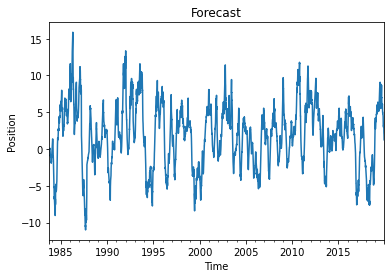

In [18]:
ewmac.plot();
plt.title('Forecast')
plt.ylabel('Position')
plt.xlabel('Time')


Did we make money?


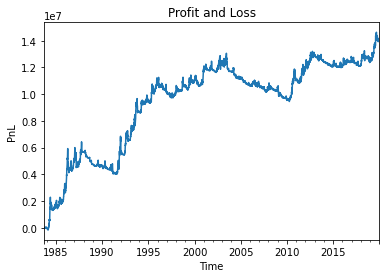

In [19]:
from syscore.accounting import accountCurve
account = accountCurve(price, forecast=ewmac)
account.curve().plot();
plt.title('Profit and Loss')
plt.ylabel('PnL')
plt.xlabel('Time');

In [20]:
account.percent().stats()

[[('min', '-10.77'),
  ('max', '5.124'),
  ('median', '0'),
  ('mean', '0.01479'),
  ('std', '0.5193'),
  ('skew', '-1.11'),
  ('ann_mean', '3.787'),
  ('ann_std', '8.308'),
  ('sharpe', '0.4558'),
  ('sortino', '0.5179'),
  ('avg_drawdown', '-11.56'),
  ('time_in_drawdown', '0.9739'),
  ('calmar', '0.1049'),
  ('avg_return_to_drawdown', '0.3277'),
  ('avg_loss', '-0.3223'),
  ('avg_gain', '0.3316'),
  ('gaintolossratio', '1.029'),
  ('profitfactor', '1.105'),
  ('hitrate', '0.5178'),
  ('t_stat', '2.769'),
  ('p_value', '0.005637')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent', 'cumulative'])]